In [113]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.preprocessing as sp
import pickle
import matplotlib.pyplot as plt
import scienceplots
import scipy
import os
import time
from datetime import date
from scipy.stats import ttest_ind
today = date.today()

import sys
# sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
sys.path.insert(0, '/home/jupyter-mhaghigh@broadinst-ee45a/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.read import read_single_cell_sql
from singlecell.preprocess import handle_nans, extract_cpfeature_names,find_highly_correlated_features
from singlecell.visualize import visualize_n_SingleCell, cluster
from singlecell.process import statistical_tests,precision_recall
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
from singlecell.save.save_pandas_dfs import saveDF_to_CSV_GZ_no_timestamp
from singlecell.preprocess.control_for_cellcount import control_feature_y_for_variable_x
from singlecell.process.abundance import abundance_rawFeature
from statsmodels.stats.outliers_influence import variance_inflation_factor
# plt.style.use('science')
# plt.style.use(['science','no-latex'])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import seaborn as sns
print(sns.__version__)
import sklearn
print(sklearn.__version__)

0.12.2
1.0.2


In [1]:
pwd

'/home/jupyter-mhaghigh@broadinst-ee45a/workspace_mito/2016_08_01_RadialMitochondriaDistribution_donna/analysis_MH/classification'

In [ ]:
df_new['Nuclei_Children_Cytoplasm_Count'].std()

## Read Data

In [2]:
%%time

home_path="/home/ubuntu/" # ec2
home_path="/home/jupyter-mhaghigh@broadinst-ee45a/" #dgx

rootDir=home_path+"bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/"

compartments = ['mito','actin','dna']
# the directory data and images are stored in
dataDir=rootDir+"workspace/singleCellData/"
imDir=rootDir+"Mito_Morphology_input/images/"
sql_data= rootDir+"workspace/backend/Mito_Morphology_input"

df_1_0_0=pd.read_pickle(dataDir+'single_cell_with_annot.pkl', compression='infer')
subject_list=os.listdir(sql_data)
sc_df_ls=[]
compartments = ["Cells","Cytoplasm","Nuclei"]
for si in subject_list:
    fileName = sql_data+'/'+si+'/'+si+'.sqlite'
    sc_df = read_single_cell_sql.readSingleCellData_sqlalch(fileName,compartments);
    sc_df['subject']=si
    sc_df_ls.append(sc_df)

df_new = pd.concat(sc_df_ls,ignore_index=True)

df_1_0=pd.read_pickle(dataDir+'single_cell_with_annot_allFeatures.pkl', compression='infer')
df_1_0 = df_1_0.interpolate()

common_subjects = list(set(df_new['subject'].unique()) & set(df_1_0['subject'].unique()))
df_1 = df_new[df_new['subject'].isin(common_subjects)]


df_1 = pd.merge(df_1, df_1_0[['subject','label']].drop_duplicates(), on='subject',how='left')

##################### Clean and shrink features
(
    cp_features,
    cp_features_analysis_0,
) = extract_cpfeature_names.extract_cpfeature_names(df_1)
df_1, cp_features_analysis = handle_nans.handle_nans(
    df_1,
    cp_features_analysis_0,
    thrsh_null_ratio=0.05,
    thrsh_std=0.001,
    fill_na_method="drop-rows",
)
    

############### remove cells on the border
borderLength=200

im_width = df_1['Width_Mito'].values[0] #1388
im_height = df_1['Height_Mito'].values[0] #1040
print(df_1.shape)
df_1_centCells=df_1.loc[~((df_1['Nuclei_Location_Center_X']>(im_width-borderLength)) | (df_1['Nuclei_Location_Center_X']<(borderLength))\
                        | (df_1['Nuclei_Location_Center_Y']>(im_height-borderLength)) | (df_1['Nuclei_Location_Center_Y']<(borderLength))),:].reset_index(drop=True)

print("After border cell removal: ",df_1_centCells.shape)

df_1_centCells['Cells2Nuclei_MajorAxisLengthRatio']=df_1_centCells['Cells_AreaShape_MajorAxisLength']/df_1_centCells['Nuclei_AreaShape_MajorAxisLength']
df_1_centCells['Cells2Nuclei_AreaShapeRatio']=df_1_centCells['Cells_AreaShape_Area']/df_1_centCells['Nuclei_AreaShape_Area']
df_1_centCells = df_1_centCells[df_1_centCells['Cells2Nuclei_MajorAxisLengthRatio']>2].reset_index(drop=True)
df_1_centCells = df_1_centCells[df_1_centCells['Cells2Nuclei_AreaShapeRatio']>5].reset_index(drop=True)

print("After cell seg pron cells removal: ",df_1_centCells.shape)

df_1= df_1_centCells[(df_1_centCells['Cells_Intensity_MeanIntensity_Actin']<.5) &\
                                (df_1_centCells['Nuclei_Intensity_MeanIntensity_Actin']<.55)].reset_index(drop=True)

print("After intensity artifact cells removal: ",df_1.shape)



# df_1=df_1_centCells.copy()

df_1, cp_features_analysis = handle_nans.handle_nans(
    df_1,
    cp_features_analysis,
    thrsh_null_ratio=0.05,
    thrsh_std=0.001,
    fill_na_method="drop-rows",
)


scaler = sp.StandardScaler()
s0=scaler.fit(df_1[cp_features_analysis])
df_1_scaled=df_1.copy()

df_1_scaled[cp_features_analysis]=s0.transform(df_1[cp_features_analysis])

similar_fs_2remove=find_highly_correlated_features.find_correlation(df_1_scaled[cp_features_analysis],\
                                                 threshold=0.7,remove_negative=True)

cp_features_collcorr=list(set(cp_features_analysis) - set(similar_fs_2remove))

# df_1['label'] = df_1['label'].replace('MDD or Dep','DEP')
# df_1_scaled['label'] = df_1_scaled['label'].replace('MDD or Dep','DEP')

df_1['label'] = df_1['label'].replace('MDD or Dep','MDD')
df_1_scaled['label'] = df_1_scaled['label'].replace('MDD or Dep','MDD')

<timed exec>:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.


cp_features: 2185


/home/jupyter-mhaghigh@broadinst-ee45a/.conda/envs/gan/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/jupyter-mhaghigh@broadinst-ee45a/.conda/envs/gan/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


cols2remove_manyNulls []
cols2remove_lowVars ['Nuclei_Texture_DifferenceVariance_Mito_5_00_256', 'Nuclei_Texture_DifferenceVariance_DNA_5_02_256', 'Nuclei_Texture_DifferenceVariance_DNA_10_03_256', 'Cells_RadialDistribution_FracAtD_mito_tubeness_CCN_1of12', 'Cells_Texture_DifferenceVariance_Actin_10_01_256', 'Nuclei_Texture_DifferenceVariance_Mito_10_03_256', 'Cytoplasm_Texture_DifferenceVariance_Mito_3_01_256', 'Cytoplasm_Texture_DifferenceVariance_Actin_3_02_256', 'Nuclei_Texture_DifferenceVariance_Actin_3_02_256', 'Cells_Texture_DifferenceVariance_Actin_3_02_256', 'Nuclei_Texture_DifferenceVariance_DNA_5_00_256', 'Cytoplasm_Texture_DifferenceVariance_Actin_5_00_256', 'Cytoplasm_Texture_DifferenceVariance_Mito_5_03_256', 'Cytoplasm_Texture_DifferenceVariance_Mito_3_00_256', 'Nuclei_Texture_DifferenceVariance_Actin_5_03_256', 'Nuclei_Texture_DifferenceVariance_Mito_5_03_256', 'Cells_Texture_DifferenceVariance_Mito_3_00_256', 'Cytoplasm_Texture_DifferenceVariance_Actin_10_01_256', 'Nuc

In [9]:
# df_1_scaled.head()

## Check the average of the full pattern for new/old features

In [3]:
from scipy.signal import find_peaks
def find_end_slope(data, height=None):
    peaks, _ = find_peaks(data, height=height,width=2)
    valleys, _ = find_peaks(-data, height=height,width=2)
#     print(valleys.dtype)
    if peaks.size == 0 and valleys.size == 0:
        return 0
    
    last_peak_ind=np.max(np.concatenate((peaks, valleys)))

    slope=data[-1]-data[last_peak_ind]
    return slope


def find_peaks_valleys(data, height=None):
    peaks, _ = find_peaks(data, height=height,width=2)
    valleys, _ = find_peaks(-data, height=height,width=2)
    return peaks, valleys

## The diff pattern to use as template for virtual screen

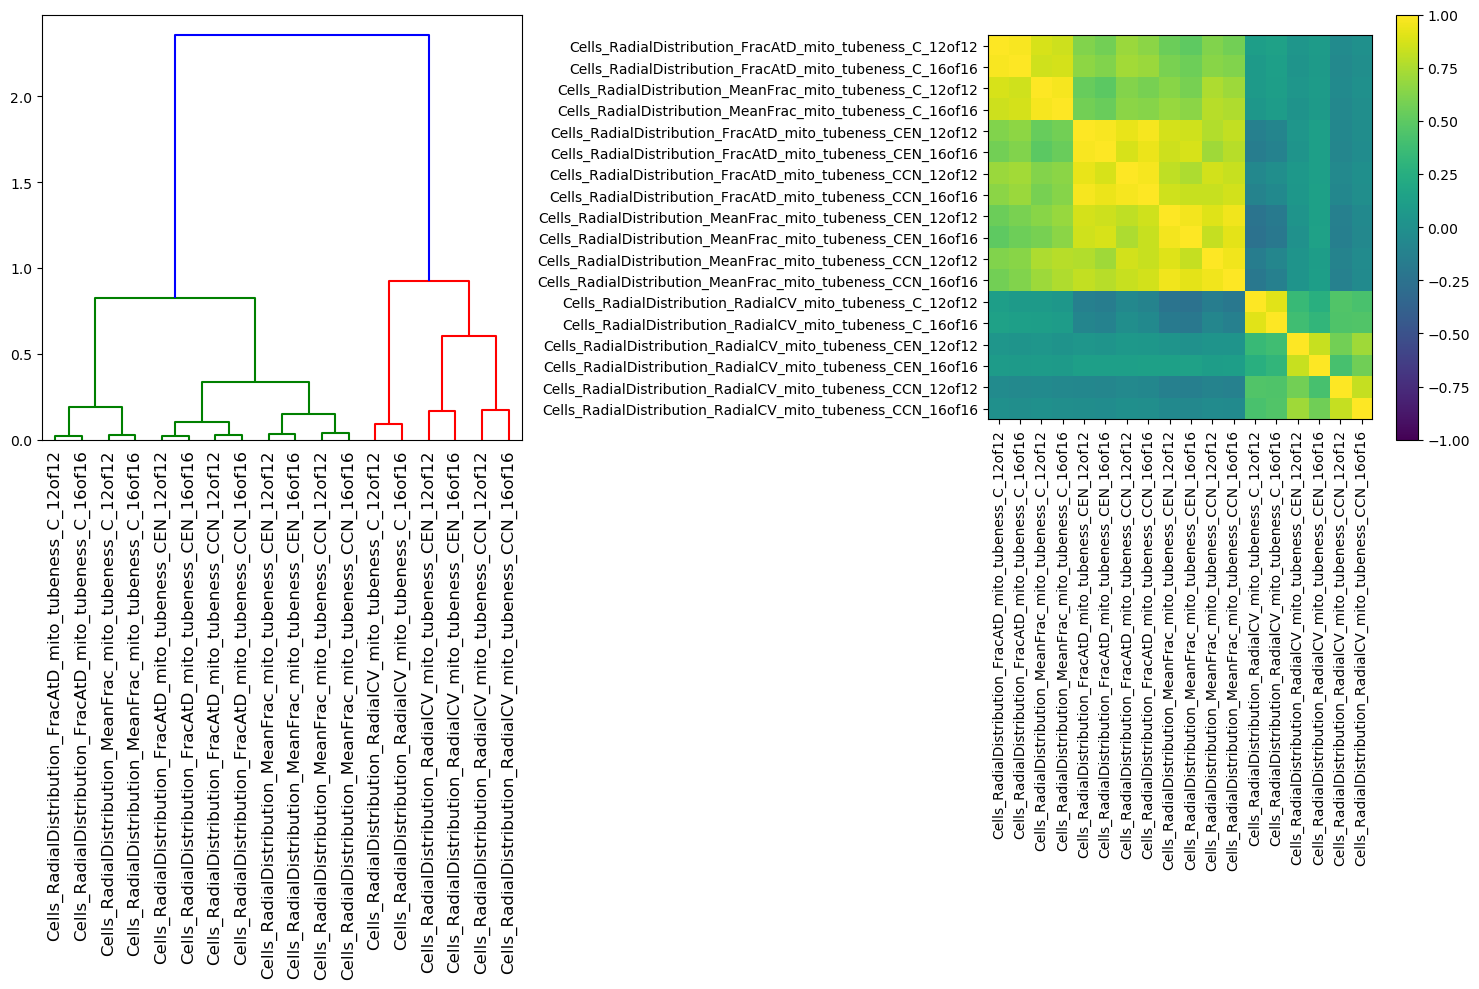

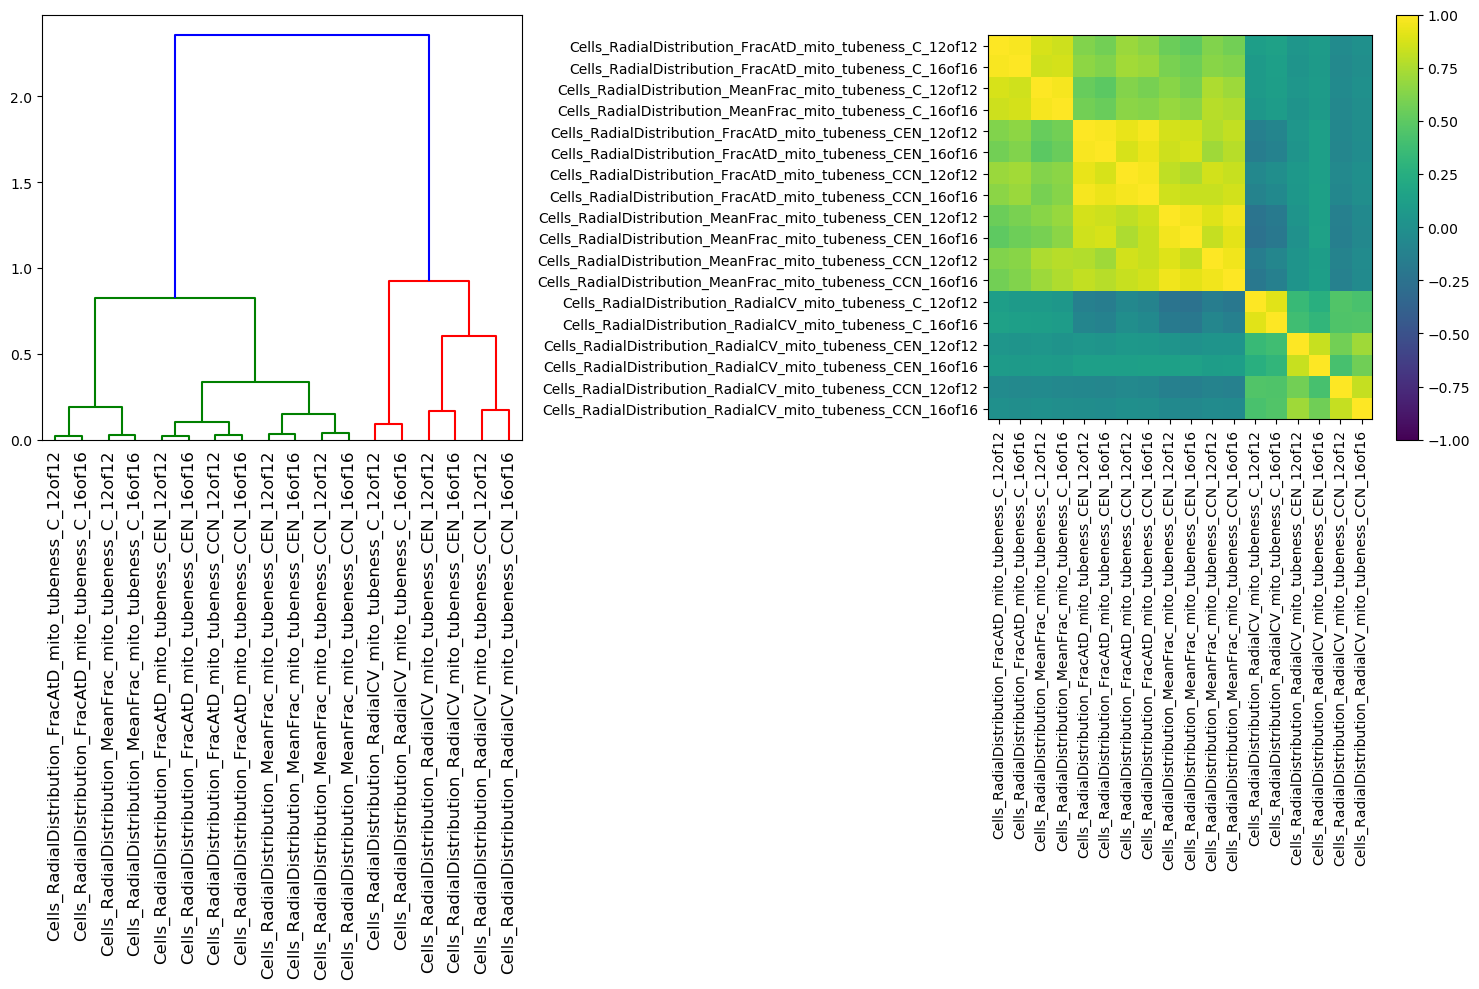

In [7]:
# fs_mito_tubeness=[f for f in cp_features_analysis_0 if '12of12' in f or '16of16' in f\
#      or '_mito_tubeness' in f]


fs_mito_tubeness = df_1_scaled.columns[
        df_1_scaled.columns.str.contains("12of12|16of16")
    ].tolist()
# fs_mito_tubeness
cluster.check_feature_similarity_dendrogram(df_1_scaled, fs_mito_tubeness,(15, 10))

## Cluster features and select median feature from each cluster

Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exc

45


Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1630 ticks ([1.0, ..., 3259.0]), which exc

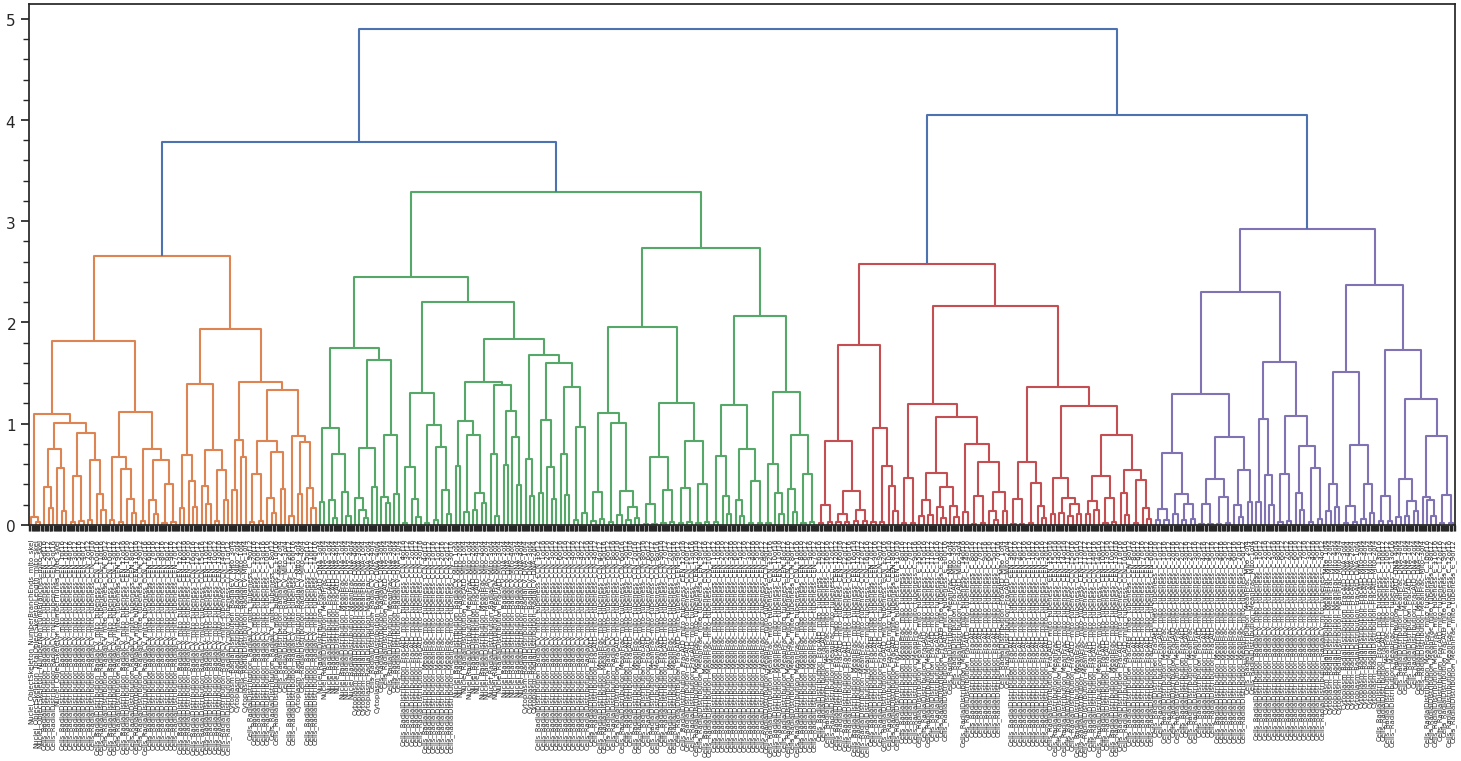

In [81]:
# from scipy.stats import spearmanr
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
# corr = spearmanr(data4DM).correlation
# data4DM_BP=df_1_scaled[(df_1_scaled['label']=='Control')|(df_1_scaled['label']==d)]
# df_1_scaled[cp_features_analysis_0] = df_1_scaled[cp_features_analysis_0].interpolate()
# mito_features = [f for f in cp_features_analysis if "mito_" in f or "Mito" in f]
mito_features = [f for f in cp_features_analysis if ("mito_" in f or "RadialDistribution" in f) and ("Actin" not in f) and ("Correlation" not in f)]
corr=df_1_scaled[mito_features].corr().values
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import hdmedians as hd


# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)

dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=mito_features, ax=ax, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
plt.tight_layout()

############################ Based on y-ax threshold form groups
from collections import defaultdict
y_ax_thsh=1.1
cluster_ids = hierarchy.fcluster(dist_linkage, y_ax_thsh, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
import hdmedians as hd
cluster_rep_feats=[]
for v in cluster_id_to_feature_ids.values():
#     print(v,df_1_scaled[filteredbyMoFnamesMito].columns[v])
#     print(df_1_scaled[df_1_scaled[filteredbyMoFnamesMito].columns[v]])
    ps_arr=df_1_scaled[df_1_scaled[mito_features].columns[v]].T.values
    gms=hd.medoid(ps_arr,axis=0)
    gm_sample_ind=np.where(np.sum((ps_arr-gms),axis=1)==0)[0]   
    cluster_rep_feats.append(df_1_scaled[mito_features].columns[v][gm_sample_ind].tolist()[0])
            
# selected_features = [v[(int(len(v)/2))-1] for v in cluster_id_to_feature_ids.values()]

# cluster_rep_feats = df_1_scaled[filteredbyMoFnamesMito].columns[selected_features]
print(len(cluster_rep_feats))

In [84]:
len(cluster_rep_feats)

45

In [100]:
# len(cluster_rep_feats)
cluster_rep_feats

['Nuclei_RadialDistribution_MeanFrac_DNA_2of4',
 'Cells_RadialDistribution_RadialCV_DNA_3of4',
 'Cytoplasm_RadialDistribution_RadialCV_Mito_2of4',
 'Cells_RadialDistribution_RadialCV_mito_tubeness_C_2of12',
 'Cells_RadialDistribution_FracAtD_mito_tubeness_CEN_3of12',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_8of12',
 'Cells_RadialDistribution_RadialCV_mito_tubeness_CEN_3of12',
 'Cells_RadialDistribution_FracAtD_mito_tubeness_CCN_9of12',
 'Cells_RadialDistribution_RadialCV_mito_tubeness_CEN_10of12',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_6of12',
 'Cells_RadialDistribution_FracAtD_mito_tubeness_CCN_16of16',
 'Nuclei_RadialDistribution_MeanFrac_Mito_3of4',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_10of12',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_C_4of12',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_2of12',
 'Cells_RadialDistribution_FracAtD_mito_tubeness_CCN_2of12',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_CCN_2of12',
 'C

## VIF for the cluster_rep_feats

In [82]:
vif_data = pd.DataFrame()
# vif_data["feature"] = cluster_rep_feats
vif_data["feature"] =cluster_rep_feats#cluster_rep_feats.tolist()+["Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16"]
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_1_scaled[cluster_rep_feats].values, i)
                          for i in range(len(cluster_rep_feats))]
# vif_data

# pd.set_option('display.width', 10)
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
# print(vif_data.to_markdown())
vif_data.sort_values(by='VIF')

,feature,VIF
37,Cytoplasm_RadialDistribution_RadialCV_DNA_2of4,1.036113
22,Nuclei_RadialDistribution_RadialCV_DNA_2of4,1.049828
33,Cells_RadialDistribution_RadialCV_mito_tubenes...,1.112135
36,Cells_RadialDistribution_RadialCV_mito_tubenes...,1.144318
41,Cells_RadialDistribution_RadialCV_mito_tubenes...,1.158371
28,Cells_RadialDistribution_RadialCV_mito_tubenes...,1.179038
3,Cells_RadialDistribution_RadialCV_mito_tubenes...,1.268994
2,Cytoplasm_RadialDistribution_RadialCV_Mito_2of4,1.276843
11,Nuclei_RadialDistribution_MeanFrac_Mito_3of4,1.280937
26,Nuclei_RadialDistribution_RadialCV_DNA_4of4,1.354545


## Checking feature importance and the permutation importance

## LogisticRegression (set dist percentile as set representation)

In [101]:
# q_auc_df.groupby(['group','Q']).size()
len(mito_features)

326

In [103]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score,balanced_accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import random

# Set random seeds for reproducibility
random.seed(1)
np.random.seed(1)
mito_features = [f for f in cp_features_analysis if ("mito_" in f or "RadialDistribution" in f) and ("Actin" not in f) and ("Correlation" not in f)]
feat = mito_features.copy()
# feat = cp_features_analysis.copy()
# feat = cluster_rep_feats.copy()

# feat=df_1_scaled.columns[df_1_scaled.columns.str.contains('MeanFrac.*_Mito')]

# df_1_ = df_1.copy()
df_1_ = df_1_scaled.copy()

disLabels=['psychosis','BP', 'SZ', 'SZA','MDD']
table_pval_ls=[]

abundance_df_all_ls=[]
mi_df_ls=[]
p_val_ls=[]
n_permutations = 10
for d in disLabels:
    
#     for qi in np.arange(0.1,1,0.1):
    qi=0.5
    sgkf = StratifiedKFold(n_splits=10)
    if d=='psychosis':
        data4DM_BP=df_1_[df_1_['label'].isin(['Control','BP', 'SZ', 'SZA'])].reset_index(drop=True)
        data4DM_BP.loc[data4DM_BP['label'].isin(['BP', 'SZ', 'SZA']),'label']='psychosis'
    else:
        data4DM_BP=df_1_[(df_1_['label']=='Control')|(df_1_['label']==d)].reset_index(drop=True)


    
    
    data4DM_BP = data4DM_BP.groupby(['subject','label'])[feat].quantile(qi).reset_index()
#     data4DM_BP = data4DM_BP.groupby(['subject','label'])[feat].mean().reset_index()
    #     scaler = preprocessing.StandardScaler()
    # (df_1_scaled['label']=='Control')|(df_1_scaled['label']=='BP'),filteredbyMoFnamesMito
    # data4DM_BP=df_1_scaled[(df_1_scaled['label']=='Control')|(df_1_scaled['label'].isin(['BP', 'SZ', 'SZA']))]\
    # .reset_index(drop=True)
    # data4DM_BP['bin_label']=1
    # data4DM_BP.loc[data4DM_BP['label']=='Control','bin_label']=0
#     data4DM_BP.groupby(['subject','label']).mean()

    data4DM = data4DM_BP.loc[:,feat];
#     le1 = sp.LabelEncoder()
#     le1.fit(["Control",d])
    le2 = sp.LabelEncoder()
#     print(le1.transform(["Control",d]))
#     labels = le1.transform(data4DM_BP['label'].values);
    data4DM_BP['bin_label']=data4DM_BP['label'].replace(['Control', d],[0, 1], inplace=False)
    labels=data4DM_BP['bin_label'].values
#     labels = le1.fit_transform(data4DM_BP['bin_label'].values);
#     groupsNum = le2.fit_transform(data4DM_BP['subject'].values);

    #     scaler.fit(data4DM)
    #     dataScaled = scaler.transform(data4DM)
    X,y=data4DM.values,labels
    mi = mutual_info_classif(X, y)
    mi_df = pd.DataFrame({'Feature': feat, 'Mutual_Info': mi}).sort_values('Mutual_Info', ascending=False)[0:10]
    mi_df['Label']=d
    mi_df_ls.append(mi_df);
    clf_ls=[]
    scores=[]
    test_ind=[]
    auc_scores=[]
    null_fold_aucs = []
    combined_null_aucs=[]
    for train_index, test_index in sgkf.split(X, y):
    #         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        clf = LogisticRegression(solver='liblinear',class_weight='balanced')
    #     clf = RandomForestClassifier(n_estimators=10,max_features=data4DM.shape[1])
        clf.fit(X_train, y_train)  
#         print(clf.classes_)
#         scores.append(clf.score(X_test, y_test)) 
        data4DM_BP.loc[test_index,'cell_scores'] = clf.predict_proba(X_test)[:, 1]

        scores.append(balanced_accuracy_score(y_test, clf.predict(X_test)))
        auc_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        clf_ls.append(clf)
        test_ind.append(test_index)

        # Null distribution for this fold
        fold_null_aucs_fold = []
        for _ in range(n_permutations):
            shuffled_y_train = np.random.permutation(y_train)
            clf.fit(X_train, shuffled_y_train)
            fold_null_aucs_fold.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

        null_fold_aucs.append(np.mean(fold_null_aucs_fold))  # Store the mean null AUC for the fold
        combined_null_aucs+=fold_null_aucs_fold
        
    print(f"Observed ROC AUC for {d}: {np.mean(auc_scores)}")

    # Calculate p-value comparing observed AUCs to null distribution
    # p_value = np.mean([1 if null_value >= np.mean(auc_scores) else 0 for null_value in null_fold_aucs])
    # Statistical test to calculate p-value
    t_stat, p_value = ttest_ind(auc_scores, combined_null_aucs, equal_var=False)
    # u_stat, p_value = mannwhitneyu(auc_scores, combined_null_aucs, alternative='greater')
    
    p_val_ls.append(np.round(p_value,5))
    # Store results in the table_pval dataframe
    table_pval = pd.DataFrame({
        'roc_auc': auc_scores,
        'null_auc': null_fold_aucs,
        'p_value': [p_value] * len(auc_scores),
        'Q': qi
    })
    table_pval['group']=d
    table_pval_ls.append(table_pval)
    # print(d,qi,'roc auc:', np.mean(auc_scores))

    # Calculate feature importances using the entire dataset
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    importances = pd.Series(result.importances_mean, index=feat).sort_values(ascending=False)
    # print(f"Top 5 features for {d}:")
    # print(importances.head(10))    
    
    
    
    best_on_val_clf=clf_ls[np.argmax(scores)]
    
    if 0:
        # result = permutation_importance(best_on_val_clf, data4DM.values, labels, n_repeats=20, random_state=42)
        result = permutation_importance(best_on_val_clf, X[test_index], y[test_index], n_repeats=20)
        perm_sorted_idx = result.importances_mean.argsort()

        # tree_importance_sorted_idx = np.argsort(best_on_val_clf.feature_importances_)
        # tree_indices = np.arange(0, len(best_on_val_clf.feature_importances_)) + 0.5

        tree_importance_sorted_idx = np.argsort(abs(best_on_val_clf.coef_[0]))
        tree_indices = np.arange(0, len(best_on_val_clf.coef_[0])) #+ 0.5

        ##############################
    #     plt_top_n=len(feat)
        plt_top_n=10
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle('Control vs '+d,fontsize=12)
        # ax1.barh(tree_indices, best_on_val_clf.coef_[0][tree_importance_sorted_idx], height=0.7)
        # ax1.set_yticks(tree_indices)
        # ax1.set_yticklabels([feat[i] for i in tree_importance_sorted_idx])
        top_feats = tree_importance_sorted_idx[-plt_top_n:]
        ax1.barh(range(plt_top_n), best_on_val_clf.coef_[0][top_feats], height=0.7)
        ax1.set_yticks(range(plt_top_n))
        ax1.set_yticklabels([feat[i] for i in top_feats])        
        
        # ax1.set_ylim((0, plt_top_n))#len(clf.feature_importances_)))
    #     perm_sorted_idx_top=len(feat)
        # perm_sorted_idx_top=perm_sorted_idx[:plt_top_n]
        perm_sorted_idx_top = perm_sorted_idx[-plt_top_n:]
        ax2.boxplot(
            result.importances[perm_sorted_idx_top].T,
            vert=False,
            labels=[feat[i] for i in perm_sorted_idx_top],
        )
        ax1.set_title('Logistic regression')
        ax2.set_title('Permutation importance')
        fig.tight_layout()
        plt.show()    
    
mi_df_all=pd.concat(mi_df_ls,ignore_index=True)

/tmp/ipykernel_66469/1581163767.py:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data4DM_BP['bin_label']=data4DM_BP['label'].replace(['Control', d],[0, 1], inplace=False)


Observed ROC AUC for psychosis: 0.6815


/tmp/ipykernel_66469/1581163767.py:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data4DM_BP['bin_label']=data4DM_BP['label'].replace(['Control', d],[0, 1], inplace=False)


Observed ROC AUC for BP: 0.7180000000000001


/tmp/ipykernel_66469/1581163767.py:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data4DM_BP['bin_label']=data4DM_BP['label'].replace(['Control', d],[0, 1], inplace=False)


Observed ROC AUC for SZ: 0.55375


/tmp/ipykernel_66469/1581163767.py:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data4DM_BP['bin_label']=data4DM_BP['label'].replace(['Control', d],[0, 1], inplace=False)


Observed ROC AUC for SZA: 0.6475


/tmp/ipykernel_66469/1581163767.py:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data4DM_BP['bin_label']=data4DM_BP['label'].replace(['Control', d],[0, 1], inplace=False)


Observed ROC AUC for MDD: 0.5516666666666665


In [111]:
p_val_ls

[0.00299, 0.00039, 0.13499, 0.02808, 0.67316]

In [51]:
# len(best_on_val_clf.coef_[0]), 
# len(permutation_importance)

/tmp/ipykernel_66469/1942085024.py:19: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(x="group", y='ROC-AUC', data=logreg_results_melted, hue='classifier',order=orderC,ax=axes,palette=palette)
/tmp/ipykernel_66469/1942085024.py:20: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.2'` for the same effect.

  sns.swarmplot(x="group", y='ROC-AUC', data=logreg_results_melted, hue='classifier',order=orderC,legend=False,dodge=True,\
/tmp/ipykernel_66469/1942085024.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([


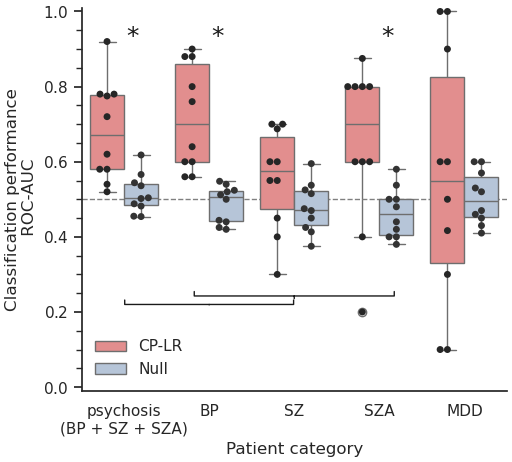

In [114]:
logreg_results=pd.concat(table_pval_ls).reset_index(drop=True)[['group','roc_auc','null_auc']].\
                    rename(columns={'roc_auc':'CP-LR','null_auc':'Null'});

logreg_results_melted=pd.melt(logreg_results, id_vars=['group'],\
                              value_vars=['CP-LR','Null']).rename(columns={'variable':'classifier','value':'ROC-AUC'})



plt.style.use(['science','no-latex','nature'])
custom_params = {"font.size":16,'xtick.bottom': True,'ytick.left': True}
sns.set_theme(style='white',rc=custom_params,font_scale=1)
# plt.rcParams['font.size'] = '16'
fig, axes = plt.subplots(1, 1, figsize=(5.5,5))
#         fig, axes = plt.subplots(len(rest_of_gmember_feats2), 1, figsize=(4, len(rest_of_gmember_feats2)*5))

orderC=["psychosis","BP","SZ","SZA","MDD"]
palette = ['lightcoral','lightsteelblue','lightcoral','firebrick','lightcoral','pink','lightgreen']

sns.boxplot(x="group", y='ROC-AUC', data=logreg_results_melted, hue='classifier',order=orderC,ax=axes,palette=palette)
sns.swarmplot(x="group", y='ROC-AUC', data=logreg_results_melted, hue='classifier',order=orderC,legend=False,dodge=True,\
              ax=axes, color=".2")
# axes.supxlabel('Year')

# fig.supylabel('Strength')
axes.set(ylabel='Classification performance\n ROC-AUC')
axes.set(xlabel='Patient category')
# axes.hlines(y=ln, xmin=-0.2, xmax=1, color="black")
axes.set_ylim([-0.01, 1.01])
axes.axhline(y=0.5,linewidth=1, color='grey',linestyle='--')
fs = 14.0
axes.annotate('', xy=(2, 0.25), xytext=(2, 0.228), fontsize=4, \
              arrowprops=dict(arrowstyle='-[, widthB=18.0, lengthB=0.8',color='k', lw=1.0))

axes.annotate('', xy=(1, 0.22), xytext=(1, 0.219), fontsize=4, \
              arrowprops=dict(arrowstyle='-[, widthB=15.2, lengthB=0.8',color='k', lw=1.0))

axes.text(0.1, 0.9, "*", ha='center', va='bottom', color='k', fontsize=18)  # Star
axes.text(1.1, 0.9, "*", ha='center', va='bottom', color='k', fontsize=18)  # Star
axes.text(3.1, 0.9, "*", ha='center', va='bottom', color='k', fontsize=18)  # Star
axes.tick_params(axis='x', bottom=False)

# Remove legend title
legend = axes.get_legend()
legend.set_title("")

# Clean up spines and ticks
sns.despine(ax=axes, top=True, right=True)
axes.tick_params(axis='x', which='both', bottom=False, top=False)

# Custom x-axis labels
axes.set_xticklabels([
    "psychosis\n(BP + SZ + SZA)",  # updated label
    "BP",
    "SZ",
    "SZA",
    "MDD"
])

fig.tight_layout()

In [160]:
# fq_all_ds[fq_all_ds[fq_all_ds["features"].isin(final_features_to_use_for_VS)].isnull().max(axis=1)]

/tmp/ipykernel_66469/2881214287.py:37: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(x="group", y='ROC-AUC', data=logreg_results_melted, hue='classifier',order=orderC,ax=axes,palette=palette)
/tmp/ipykernel_66469/2881214287.py:38: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.2'` for the same effect.

  sns.swarmplot(x="group", y='ROC-AUC', data=logreg_results_melted, hue='classifier',order=orderC,legend=False,dodge=True,\
/tmp/ipykernel_66469/2881214287.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([


[Text(0, 0, 'psychosis\n(BP + SZ + SZA)'),
 Text(1, 0, 'BP'),
 Text(2, 0, 'SZ'),
 Text(3, 0, 'SZA'),
 Text(4, 0, 'MDD')]

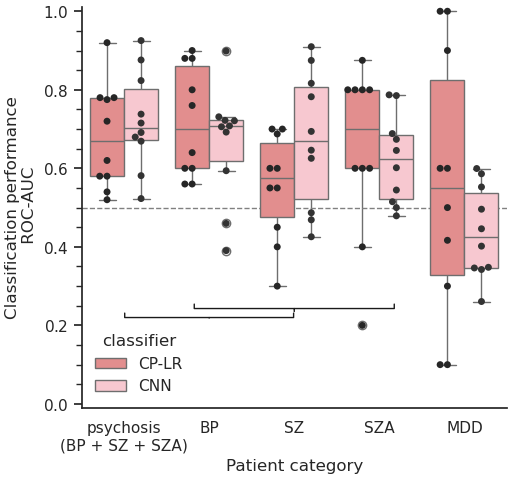

In [121]:
# %matplotlib widget
# Load the list
# with open('table_pval_ls.pkl', 'rb') as file:
#     table_pval_ls = pickle.load(file)
logreg_results=pd.concat(table_pval_ls).reset_index(drop=True)[['group','roc_auc']].rename(columns={'roc_auc':'CP-LR'})
# logreg_results['group'] = logreg_results['group'].replace('MDD or Dep','DEP')

# final auc for all k folds BP:  
BP_auc_ls=[0.8985372160826309, 0.7210214913425563, 0.7312030731622141, 0.705807092764119, 0.3903200167002122, 0.5938957214619782, 0.45968212498917704, 0.722077046835305, 0.6922448186348683, 0.708013408009809]
# final auc for all k folds Dep 
Dep_auc_ls=[0.5994753158698828, 0.5860629451467353, 0.3423604298617395, 0.3462297189137401, 0.49591034575913967, 0.26077571138371414, 0.44603453057219256, 0.5524965945267961, 0.40185182614489773, 0.3479176258738351]
# final auc for all k folds SZA 
SZA_auc_ls=[0.6014866360120785, 0.7852295185889547, 0.7871225613918122, 0.6455730476153638, 0.47899886916343776, 0.5149331527644363, 0.4999968629104411, 0.6738445892894702, 0.5447309021752711, 0.6885026688194275]
# final auc for all k folds SZ 
SZ_auc_ls=[0.9097696940860435, 0.6940000745795578, 0.6461828341032113, 0.8165253846451386, 0.4868552808281341, 0.8747876478276617, 0.4688405442473934, 0.6254893475036256, 0.4256557047073032, 0.7822706248673656]

psychosis_ls=[0.9253194012318833, 0.7379870977365104, 0.7153102528691841, 0.6796586618425476, 0.5229692106582183, 0.8759334204683245, 0.5813321839037189, 0.6912499435632977, 0.6690856087843747, 0.8234750622683167]

logreg_results.loc[logreg_results['group']=='psychosis','CNN']=psychosis_ls
logreg_results.loc[logreg_results['group']=='BP','CNN']=BP_auc_ls
logreg_results.loc[logreg_results['group']=='MDD','CNN']=Dep_auc_ls
logreg_results.loc[logreg_results['group']=='SZA','CNN']=SZA_auc_ls
logreg_results.loc[logreg_results['group']=='SZ','CNN']=SZ_auc_ls
logreg_results_melted=pd.melt(logreg_results, id_vars=['group'], value_vars=['CP-LR','CNN']).rename(columns={'variable':'classifier','value':'ROC-AUC'})
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params,font_scale=1)
plt.style.use(['science','no-latex','nature'])
custom_params = {"font.size":16,'xtick.bottom': True,'ytick.left': True}
sns.set_theme(style='white',rc=custom_params,font_scale=1)
# plt.rcParams['font.size'] = '16'
fig, axes = plt.subplots(1, 1, figsize=(5.5,5))
#         fig, axes = plt.subplots(len(rest_of_gmember_feats2), 1, figsize=(4, len(rest_of_gmember_feats2)*5))

orderC=["psychosis","BP","SZ","SZA","MDD"]
palette = ['lightcoral','pink','lightsteelblue','lightcoral','firebrick','lightcoral','pink','lightgreen']

sns.boxplot(x="group", y='ROC-AUC', data=logreg_results_melted, hue='classifier',order=orderC,ax=axes,palette=palette)
sns.swarmplot(x="group", y='ROC-AUC', data=logreg_results_melted, hue='classifier',order=orderC,legend=False,dodge=True,\
              ax=axes, color=".2")
# axes.supxlabel('Year')

# fig.supylabel('Strength')
axes.set(ylabel='Classification performance\n ROC-AUC')
axes.set(xlabel='Patient category')
axes.set_ylim([-0.01, 1.01])

# axes.hlines(y=ln, xmin=-0.2, xmax=1, color="black")
axes.axhline(y=0.5,linewidth=1, color='grey',linestyle='--')
fs = 14.0
# axes.annotate('', xy=(2, 0.25), xytext=(2, 0.228), fontsize=4, \
#               arrowprops=dict(arrowstyle='-[, widthB=18.0, lengthB=0.8',color='k', lw=1.0))

# axes.annotate('', xy=(1, 0.22), xytext=(1, 0.219), fontsize=4, \
#               arrowprops=dict(arrowstyle='-[, widthB=14.6, lengthB=0.8',color='k', lw=1.0))

axes.annotate('', xy=(2, 0.25), xytext=(2, 0.228), fontsize=4, \
              arrowprops=dict(arrowstyle='-[, widthB=18.0, lengthB=0.8',color='k', lw=1.0))

axes.annotate('', xy=(1, 0.22), xytext=(1, 0.219), fontsize=4, \
              arrowprops=dict(arrowstyle='-[, widthB=15.2, lengthB=0.8',color='k', lw=1.0))

fig.tight_layout()
# Clean up spines and ticks
sns.despine(ax=axes, top=True, right=True)
axes.tick_params(axis='x', which='both', bottom=False, top=False)

# Custom x-axis labels
axes.set_xticklabels([
    "psychosis\n(BP + SZ + SZA)",  # updated label
    "BP",
    "SZ",
    "SZA",
    "MDD"
])


In [116]:
logreg_results.loc[logreg_results['group']=='DEP'].shape
# =Dep_auc_ls

(0, 3)

In [ ]:
## Median
psychosis 0.5 roc auc: 0.6535
BP 0.5 roc auc: 0.72
SZ 0.5 roc auc: 0.65
SZA 0.5 roc auc: 0.6625
DEP 0.5 roc auc: 0.62

In [ ]:
orderC

## Considering the full Rings pattern
- MITO-SLOPE

In [105]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

# Define a function to smooth the data using a Savitzky-Golay filter
def smooth_data(data, window_length=5, polyorder=3):
    return savgol_filter(data, window_length, polyorder)


def find_dom_freq(signal, fs=100):
    # compute the Fourier transform and the spectral density
    ft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/fs)
    spectrum = np.abs(ft)**2

    # find the frequency where the spectral density is maximum
    index_max = np.argmax(spectrum)
    f_dom = abs(freqs[index_max])

    # find the phase of the signal at that frequency
    phase = np.angle(ft[index_max])
    
    return f_dom, phase

# Apply the function to each row and split the returned tuples into two separate series

from scipy.signal import find_peaks
def find_end_slope(data, height=None):
    peaks, _ = find_peaks(data, height=height,width=1)
    valleys, _ = find_peaks(-data, height=height,width=1)
#     print(valleys.dtype)
    if peaks.size == 0 and valleys.size == 0:
        return 0
    
#     last_peak_ind=np.max(np.concatenate((peaks, valleys)))
    slope=data[-1]-data[last_peak_ind]
    return slope

def find_end_slope2(data, height=None, plot=False, subject=None,smooth=False):
#     peaks, _ = find_peaks(data, height=height,width=2)
#     valleys, _ = find_peaks(-data, height=height,width=2)
# #     print(valleys.dtype)
#     if peaks.size == 0 and valleys.size == 0:
#         return 0
    if smooth:
        data = smooth_data(data)
    
#     min_max_indc = [np.argmax(data[3:] + 3), np.argmin(data[3:] + 3)]
#     min_max_indc=[np.argmax(data[2:])+2, np.argmin(data[2:])+2]
    min_max_indc=[np.argmax(data), np.argmin(data)]
#     print(min_max_indc,len(data)-2)
    last_peak_ind0=[i for i in min_max_indc if (i<len(data)-2)]# and (i>0)]
    if last_peak_ind0==[]:
        return 0
    
    
    
    last_peak_ind=np.max(last_peak_ind0)
#     slope=data[-1]-data[last_peak_ind]
#     last_two_points_amplitude = (data[-1] + data[-2]) / 2
    slope = (data[-1] - data[last_peak_ind]) / (len(data) - last_peak_ind-1)
#     print(slope,len(data) , last_peak_ind)
#     last_peak_ind=np.max(np.concatenate((peaks, valleys)))
#     slope=data[-1]-data[-3]
    # If plot flag is enabled, create plot
    if plot:
        plt.figure()
        x_values = range(len(data))
        plt.plot(x_values, data, label="Data", color="blue",linestyle='-', marker='o')
        y_values_slope = [data[last_peak_ind] + slope * (x - last_peak_ind) for x in x_values]
        plt.ylim([-1.5,1.5])
        plt.plot(x_values, y_values_slope, label="Slope", color="red")
        plt.savefig(rootDir+"/workspace/results/slope_subjects_donna2/"+subject+'_smooth.png')
        
        plt.legend()
        plt.show()
#         plt.pause(0.01)

    return last_peak_ind, slope


# def find_end_slope2(data, height=None, plot=False, subject=None,smooth=False):
#     data = smooth_data(data)
#     #     min_max_indc = [np.argmax(data[3:] + 3), np.argmin(data[3:] + 3)]
#     min_max_indc = [np.argmax(data), np.argmin(data)]
#     last_peak_ind0 = [i for i in min_max_indc if i < len(data) - 2]
#     if last_peak_ind0 == []:
#         return 0, 0
#     last_peak_ind = np.max(last_peak_ind0)
#     last_two_points_amplitude = (data[-1] + data[-2]) / 2
#     slope = (last_two_points_amplitude - data[last_peak_ind]) / (
#         len(data) - last_peak_ind - 1
#     )

#     #     last_peak_ind = 0
#     #     slope = data[-2]  # - data[-2]
#     return last_peak_ind, slope

/tmp/ipykernel_66469/95281950.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y=targetFeature, data=data_phs,order=orderC,ax=axes,palette=palette,boxprops={'edgecolor':'none'})


0.0046
0.0045
0.014
0.55
0.17


/tmp/ipykernel_66469/95281950.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labels)


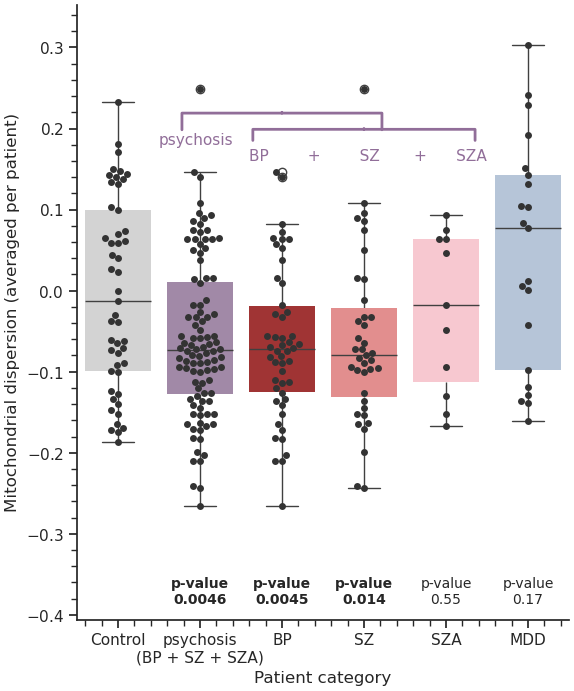

In [108]:
plt.style.use(['science','no-latex','nature'])
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params,font_scale=1)

def round_sig(x, sig=2):
    if x == 0:
        return 0
    return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

f_substr='MeanFrac'
# 
# f_substr='RadialCV'
# f_substr='FracAtD'

df_1_=df_1_scaled.copy()
# df_1_=df_1.copy()

# for pat in ['CEN','CCN','C']:
#     for ring in ['12','16']:
        
import scipy.stats as stats

for pat in ['CEN']:
    for ring in ['12']:
        if 1:
            target_columns=["Cells_RadialDistribution_"+f_substr+"_mito_tubeness_"+pat+"_"+str(i)+"of"+ring \
                            for i in range(int(ring)-11,int(ring)+1)]
#                             for i in range(int(ring)-6,int(ring)+1)]
#             data_2plot=df_1_.groupby("label").mean()[target_columns]
#             df_1_['cc_2control_avg']=df_1_[target_columns].T.corrwith(data_2plot.loc['Control'])


#             -----------------------
            df_1_avg_persub=df_1_.groupby(["subject","label"])[target_columns].mean().reset_index()
    
            if 0:
                df_1_avg_persub['dom_freq'], df_1_avg_persub['phase'] = zip(*df_1_avg_persub[target_columns].apply(find_dom_freq, axis=1))

                df_1_scaled['dom_freq'], df_1_scaled['phase'] = zip(*df_1_scaled[target_columns].apply(find_dom_freq, axis=1))

                lda = LDA()
                qda = QDA()

                df_1_scaled['label_DC']=df_1_scaled['label']=='Control'

                df_1_scaled['lda_scores'] = lda.fit_transform(df_1_scaled[target_columns], df_1_scaled['label_DC'])  
                qda.fit(df_1_scaled[target_columns], df_1_scaled['label_DC'])


                df_1_scaled['qda_scores'] = qda.predict(df_1_scaled[target_columns])   

                qda = QDA()
                qda.fit(df_1_scaled[target_columns], df_1_scaled['label'])


    #             df_1_scaled[['qda_s'+str(i) for i in range(1,5)]]
                df_1_scaled[['qda_s'+str(i) for i in range(1,6)]]= qda.predict_proba(df_1_scaled[target_columns])   

                pca = PCA(n_components=1)
                df_1_scaled['pca_scores']= pca.fit_transform(df_1_scaled[target_columns]) 

                targetFeature='phase'
    #             targetFeature='lda_scores'
            
        

#                 tar_pop=df_1_scaled[df_1_scaled['label']==di][target_columns].mean()
                
                
            ctrl=df_1_avg_persub[df_1_avg_persub['label']=='Control'][target_columns]
            diff_pattern=df_1_avg_persub[target_columns]-ctrl.mean()
            diff_pattern['subject']=df_1_avg_persub['subject']
            diff_pattern['label']=df_1_avg_persub['label']
#                 plt.plot(diff_pattern,line)
#                 peaks, valleys = find_peaks_valleys(diff_pattern.values)

            df_1_avg_persub[["peak","slope"]] = diff_pattern.apply(lambda x: find_end_slope2(x[target_columns]\
                                        ,plot=False,subject=x['subject'],smooth=True), axis=1,result_type='expand')
            targetFeature='slope'

#             scaler = sp.StandardScaler()
#             df_1_avg_persub[["peak","slope"]]=scaler.fit_transform(df_1_avg_persub[["peak","slope"]])
            
#                 slope=find_end_slope(diff_pattern.values)

            if 0:
                
                labels=["Control","BP","SZ","SZA","DEP"]
                colors = ['gray','firebrick','lightcoral','pink','lightsteelblue']
                color_dict = dict(zip(labels, colors))  # create a dictionary mapping labels to colors

                fig, ax = plt.subplots(1,2,figsize=(8,4))
                fig.subplots_adjust(wspace=0.4,bottom=0.5)
#                 fig.suptitle(pat+'  '+ring);

                means = df_1_.groupby("label").mean()[target_columns]
                std_dev = df_1_.groupby("label").std()[target_columns]
                counts = df_1_.groupby("label").count()[target_columns]
                standard_errors = std_dev / np.sqrt(counts)


                means.T.plot(yerr=standard_errors.T, ax=ax[1], capsize=4, linestyle='-', marker='o', ecolor='black') 
                ax[1].set_ylabel('Standardized feature values', fontsize=12)
#                 ax[1].set_ylabel('Control average subtracted feature values', fontsize=12)
                ax[1].legend().set_visible(False)
                
    #             means.groupby("label").mean()[target_columns].T.plot(kind='bar', yerr=errors.T,ax=ax[0]);
                df_1.groupby("label").mean()[target_columns].T.plot(ax=ax[0]);
                ax[0].set_ylabel('Raw feature values', fontsize=12)
                ax[0].legend(loc='lower left') 
                
                labels = [item.get_text() for item in plt.gca().get_xticklabels()]
                new_labels = [label.split('_')[-1] for label in labels]
                
                for axes in ax:
                    axes.set_xticklabels(new_labels)
                    axes.tick_params(axis='y', labelsize=8)  # Reduce the size of y-axis tick labels
                    axes.tick_params(axis='x', labelsize=10)  # Reduce the size of y-axis tick labels
                    axes.tick_params(axis='x', labelrotation=90)  # Rotate x-tick labels by 90 degrees
                    
                    for line, name in zip(axes.lines, means.index):
                        line.set_color(color_dict[name])                    
                    
                plt.tight_layout()
#                 plt.subplots_adjust(bottom=0.85, top=0.15)

        # targetFeature="Cells2Nuclei_MajorAxisLengthRatio"
        else:
            targetFeature='Cells_RadialDistribution_MeanFrac_mito_tubeness_'+pat+'_'+ring+'of'+ring
            df_1_avg_persub=df_1_.groupby(["subject","label"]).mean().reset_index()

            
        # plt.rcParams['font.size'] = '10'
        data_phs0 = df_1_avg_persub.groupby(['label','subject']).mean().reset_index()
        data_phs_psych=data_phs0[data_phs0['label'].isin(["BP","SZ","SZA"])].copy()
        data_phs_psych['label']='psychosis'
        data_phs=pd.concat([data_phs0,data_phs_psych],ignore_index=True)

        fig, axes = plt.subplots(1, 1, figsize=(6,7))
        # mediumvioletred
        orderC=["Control","psychosis","BP","SZ","SZA","MDD"]
        # palette = ['lightsteelblue','#a484ac','firebrick','lightcoral','pink','lightgreen']
        palette = ['lightgray','#a484ac','firebrick','lightcoral','pink','lightsteelblue']

        sns.boxplot(x="label", y=targetFeature, data=data_phs,order=orderC,ax=axes,palette=palette,boxprops={'edgecolor':'none'})
        sns.swarmplot(x="label", y=targetFeature, data=data_phs,order=orderC,ax=axes, color=".2")
        ############################
        mi,ma=data_phs[targetFeature].describe()[['min','max']]
        # data_phs.loc[data_phs['label']=='Control',targetFeature]

        for i in range(len(orderC)):
            if orderC[i]!='Control':
                pval=round_sig(ttest_ind(data_phs.loc[data_phs['label']=='Control',targetFeature].values,\
                          data_phs.loc[data_phs['label']==orderC[i],targetFeature].values,equal_var=False).pvalue,2)
        #         pval=np.round(ps_ttest_all_cats[(ps_ttest_all_cats['feature']==targetFeature) & \
        #                                    (ps_ttest_all_cats['label']==orderC[i])]['p'].values[0],4)
            #     pvl = pvals[i]#p.get_width()
                print(pval)
                if pval<0.05:
                    weight_f='bold'
                else:
                    weight_f=None
                axes.annotate('p-value\n'+str(pval),xy=(i,mi-0.12),horizontalalignment='center',size='small',weight=weight_f)

        axes.set_ylim([mi-0.14,ma+0.05]);    

        #         axes.set_title(pat+'  '+ring);

        ofset1=1
        ofset2=1.04
        axes.annotate('', xy=(3, 1.199-ofset1), xytext=(3, 1.20-ofset1), fontsize=4, \
                      arrowprops=dict(arrowstyle='-[, widthB=20.0, lengthB=2',color='#916e99', lw=2.0))

        axes.annotate('', xy=(2, 1.259-ofset2), xytext=(2, 1.26-ofset2), fontsize=4, \
                      arrowprops=dict(arrowstyle='-[, widthB=18, lengthB=3',color='#916e99', lw=2.0))
        axes.text(x=0.5,y=0.18,s='psychosis',color='#916e99',fontsize=11)
        axes.text(x=1.6,y=0.16,s='BP        +        SZ       +      SZA',color='#916e99',fontsize=11)
        
        axes.set(ylabel='Mitochondrial dispersion (averaged per patient)')
#         axes.set(ylabel='Full Mito Rings Pattern score (averaged per patient)')
        # axes.set(ylabel='Mito-Slope '+f_substr+' Pattern score (averaged per patient)')
        axes.set(xlabel='Patient category')
        plt.tight_layout()
        
        labels = [tick.get_text() for tick in axes.get_xticklabels()]
        labels[1] = "psychosis\n(BP + SZ + SZA)"
        axes.set_xticklabels(labels)

<IPython.core.display.Javascript object>


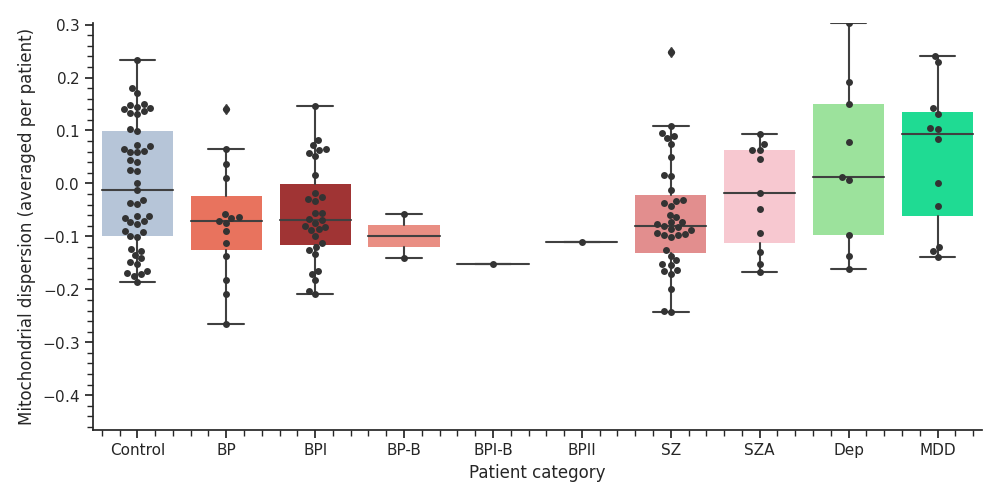

/tmp/ipykernel_15113/3915100024.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pvl=ttest_ind(data_phs.loc[data_phs['D1']=='Control',targetFeature].values,\
/home/jupyter-mhaghigh@broadinst-ee45a/.conda/envs/gan/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/jupyter-mhaghigh@broadinst-ee45a/.conda/envs/gan/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [27]:
plt.style.use(['science','no-latex','nature'])
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params,font_scale=1)



disease_labels=pd.read_excel(home_path+"bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/\
workspace/metadata/patient_labels.xlsx")
disease_labels=disease_labels.rename(columns={"ID": "subject"})
disease_labels["subject"]=disease_labels["subject"].astype(str)


# data_phs0 = df_1_scaled.groupby(['label','subject']).mean().reset_index()
# data_phs_psych=data_phs0[data_phs0['label'].isin(["BP","SZ","SZA"])].copy()
# data_phs_psych['label']='psychosis'
# data_phs=pd.concat([data_phs0,data_phs_psych],ignore_index=True)

data_phs_collapsed=pd.merge(data_phs0,disease_labels,on=["subject"],how="left")
data_phs=pd.merge(data_phs0,disease_labels,on=["subject"],how="left")


# orderC=['BP', 'BPI','BP-B', 'BPI-B','BPII', 'Control', 'Dep','MDD', 'SZA', 'SZ']




# plt.style.use(['science','no-latex','nature'])
# plt.style.use(['science','no-latex'])
# fig, axes = plt.subplots(1, 1, figsize=(6,7))
# mediumvioletred
orderC=['Control','BP', 'BPI','BP-B', 'BPI-B','BPII', 'SZ', 'SZA','Dep','MDD']
# orderC=["Control","psychosis","BP","SZ","SZA","DEP"]
palette = ['lightsteelblue','tomato','firebrick','salmon','lightcoral','pink','lightcoral','pink','lightgreen','mediumspringgreen']

# ax=sns.boxplot(x="D1", y=targetFeature, data=data_phs)#,order=orderC,ax=axes,palette=palette,boxprops={'edgecolor':'none'})
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# sns.swarmplot(x="label", y=targetFeature, data=data_phs,order=orderC,ax=axes, color=".2")
fig, axes = plt.subplots(1, 1, figsize=(10,5))
# mediumvioletred
# palette = ['lightsteelblue','mediumvioletred','firebrick','lightcoral','pink','lightgreen']
# data_phs_collapsed=data_phs_collapsed[(data_phs_collapsed['D2'].isnull()) & (data_phs_collapsed['D3'].isnull())]

sns.boxplot(x="D1", y=targetFeature, data=data_phs_collapsed,order=orderC,ax=axes,palette=palette,boxprops={'edgecolor':'none'})
sns.swarmplot(x="D1", y=targetFeature, data=data_phs_collapsed,order=orderC,ax=axes, color=".2")
############################
mi,ma=data_phs[targetFeature].describe()[['min','max']]
# data_phs.loc[data_phs['label']=='Control',targetFeature]


for i in range(len(orderC)):
    if orderC[i]!='Control':
        pvl=ttest_ind(data_phs.loc[data_phs['D1']=='Control',targetFeature].values,\
                  data_phs.loc[data_phs['D1']==orderC[i],targetFeature].values,equal_var=False).pvalue
#         pval=np.round(ps_ttest_all_cats[(ps_ttest_all_cats['feature']==targetFeature) & \
#                                    (ps_ttest_all_cats['label']==orderC[i])]['p'].values[0],4)
    #     pvl = pvals[i]#p.get_width()
    
        if 0:
            print(pvl)
            if pvl<0.05:
                if pvl<0.0001:
                    pval=pvl
                else:
                    pval=np.round(pvl,4)
                weight_f='bold'
                axes.annotate('p-value\n'+str(pval),xy=(i,mi-0.17),horizontalalignment='center',size='small',weight=weight_f)
            else:
                pval=np.round(pvl,2)
                weight_f=None
#         axes.annotate('p-value\n'+str(pval),xy=(i,mi-0.17),horizontalalignment='center',size='small',weight=weight_f)
        
axes.set_ylim([mi-0.2,ma]);       

# axes.annotate('', xy=(3, 1.199), xytext=(3, 1.20), fontsize=4, \
#               arrowprops=dict(arrowstyle='-[, widthB=20.0, lengthB=2', lw=1.0))

# axes.annotate('', xy=(2, 1.259), xytext=(2, 1.26), fontsize=4, \
#               arrowprops=dict(arrowstyle='-[, widthB=18, lengthB=3', lw=1.0))

axes.set(ylabel='Mitochondrial dispersion (averaged per patient)')
axes.set(xlabel='Patient category')
plt.tight_layout()

In [18]:
counts

,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_1of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_2of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_3of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_4of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_5of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_6of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_7of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_8of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_9of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_10of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_11of12,Cells_RadialDistribution_MeanFrac_mito_tubeness_CEN_12of12
label,,,,,,,,,,,,
BP,11898,11898,11898,11898,11898,11898,11898,11898,11898,11898,11898,11898
Control,11009,11009,11009,11009,11009,11009,11009,11009,11009,11009,11009,11009
MDD,4210,4210,4210,4210,4210,4210,4210,4210,4210,4210,4210,4210
SZ,9770,9770,9770,9770,9770,9770,9770,9770,9770,9770,9770,9770
SZA,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680


## Paper Figure

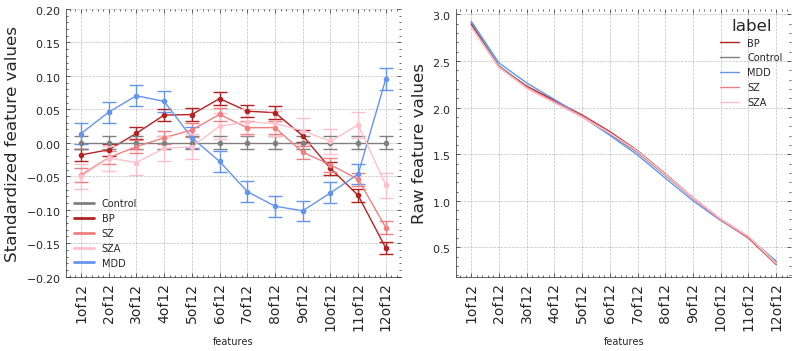

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
plt.style.use(['science','no-latex','nature'])
labels = ["Control","BP","SZ","SZA","MDD"]
# colors = ['lightsteelblue','firebrick','lightcoral','pink','lightgreen']
# colors = ['cornflowerblue','firebrick','lightcoral','pink','limegreen']
colors = ['gray','firebrick','lightcoral','pink','cornflowerblue']
color_dict = dict(zip(labels, colors)) 

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.subplots_adjust(wspace=0.5, bottom=0.5)
sns.set_style("whitegrid")

means = df_1_scaled.groupby("label").mean()[target_columns]

means=means-means.loc['Control']

std_dev = df_1_scaled.groupby("label").std()[target_columns]
counts = df_1_scaled.groupby("label").count()[target_columns]
standard_errors = std_dev / np.sqrt(counts)

#             ctrl=df_1_[df_1_['label']=='Control'][target_columns].mean()
            
#             for di in ['psychosis', 'BP', 'SZ', 'SZA', 'DEP']:
#                 if di=='psychosis':
#                     tar_pop=df_1_[df_1_['label'].isin(["BP","SZ","SZA"])][target_columns].mean()
#                 else:
#                     tar_pop=df_1_[df_1_['label']==di][target_columns].mean()
                    
#                 diff_pattern=tar_pop-ctrl

# for the scaled data
scaled_data = means.T.reset_index().melt(id_vars='index', var_name='label')
scaled_data.columns = ['features', 'label', 'mean']
# scaled_data['se'] = std_dev.T.reset_index().melt(id_vars='index').value
scaled_data['se'] = (std_dev / np.sqrt(counts)).T.reset_index().melt(id_vars='index').value

scaled_data['features'] = scaled_data['features'].apply(lambda x: x.split('_')[-1])

for label, group in scaled_data.groupby('label'):
    sns.lineplot(x=group['features'], y=group['mean'], color=color_dict[label], ax=ax[0])  # Add this line
    ax[0].errorbar(group['features'], group['mean'], yerr=group['se'], 
                   fmt='o', capsize=5, label=label, color=color_dict[label])

ax[0].set_ylabel('Standardized feature values', fontsize=12)
# ax[0].legend().set_visible(False)


# Custom legend with lines only (no error bars)
legend_handles = [Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in labels]
ax[0].legend(handles=legend_handles, title="", loc="lower left")
ax[0].set_ylim([-.2,.2]);

# for the raw data
raw_data = df_1.groupby("label").mean()[target_columns].T.reset_index().melt(id_vars='index', var_name='label')
raw_data.columns = ['features', 'label', 'mean']
raw_data['features'] = raw_data['features'].apply(lambda x: x.split('_')[-1])

sns.lineplot(data=raw_data, x='features', y='mean', hue='label', 
             palette=color_dict, ax=ax[1], legend='brief')
ax[1].set_ylabel('Raw feature values', fontsize=12)

# rotate x-axis labels and adjust the size
for axes in ax:
    axes.tick_params(axis='x', labelrotation=90, labelsize=10)
    axes.tick_params(axis='y', labelsize=8)
    axes.grid(True, linestyle='--', which='major', color='gray', alpha=.5)

plt.tight_layout()

# Save only the first subplot (ax[0]) as an SVG file
# fig.savefig("scaled_features.png", format="png", bbox_inches=ax[0].get_tightbbox(fig.canvas.get_renderer()))

In [ ]:
## feature space that doesnt chan